# NVIDIA AI Foundation Endpoints

The `NVIDIA` and `ImageGenNVIDIA` classes are LLM-inheriting connectors that interface with the [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/).


> [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/) give users easy access to NVIDIA hosted API endpoints for NVIDIA AI Foundation Models like Mixtral 8x7B, Llama 2, Stable Diffusion, etc. These models, hosted on the [NVIDIA NGC catalog](https://catalog.ngc.nvidia.com/ai-foundation-models), are optimized, tested, and hosted on the NVIDIA AI platform, making them fast and easy to evaluate, further customize, and seamlessly run at peak performance on any accelerated stack.
> 
> With [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/), you can get quick results from a fully accelerated stack running on [NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/). Once customized, these models can be deployed anywhere with enterprise-grade security, stability, and support using [NVIDIA AI Enterprise](https://www.nvidia.com/en-us/data-center/products/ai-enterprise/).
> 
> These models can be easily accessed via the [`langchain-nvidia-ai-endpoints`](https://pypi.org/project/langchain-nvidia-ai-endpoints/) package, as shown below.

This example goes over how to use LangChain to interact with and develop LLM-powered systems using the publicly-accessible AI Foundation endpoints.

## Installation

In [1]:
# %pip install --upgrade --quiet langchain-nvidia-ai-endpoints

## Setup

**To get started:**

1. Create a free account with the [NVIDIA NGC](https://catalog.ngc.nvidia.com/) service, which hosts AI solution catalogs, containers, models, etc.

2. Navigate to `Catalog > AI Foundation Models > (Model with API endpoint)`.

3. Select the `API` option and click `Generate Key`.

4. Save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [2]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

## Image Generation Models

Due to the similarity of the underlying API, a selection of **Image Generation Models** can be supported using the LLM interface. One example is the [**Stable Diffusion XL**](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/sdxl/api) model, which expects a prompt and some other arguments as input and produces an image (passed back as a b64-encoded string). 

In [3]:
from langchain_nvidia_ai_endpoints.runnables import RunnableNVIDIA

RunnableNVIDIA.get_available_models("nvidia")  ## Only shows models supported by ImageGenNVIDIA

[Model(id='stabilityai/sdxl-turbo', model_type='genai'),
 Model(id='stabilityai/stable-diffusion-xl', model_type='genai'),
 Model(id='stabilityai/stable-video-diffusion', model_type='genai')]

To see the image, we can either convert it manually or use the built-in conversion utility ``

In [4]:
sdxl = RunnableNVIDIA(
    ## Model should always be provided to provide URL lookup
    model = "stabilityai/stable-diffusion-xl",
    ## Aerguments can be stored as override-able defaults
    seed = 0,
    cfg_scale = 5,
    sampler = "K_DPM_2_ANCESTRAL",
    steps = 25
)

payload = {
    "text_prompts": [
		{
			"text": "Cool Russian white cat with green eyes playing in the grass",
			"weight": 1
		},
		{
			"text": "",
			"weight": -1
		}
	],
    "seed": 42
}

response = sdxl.invoke(payload)

In [5]:
str(response)[:200] + "..."

"{'artifacts': [{'base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUF..."

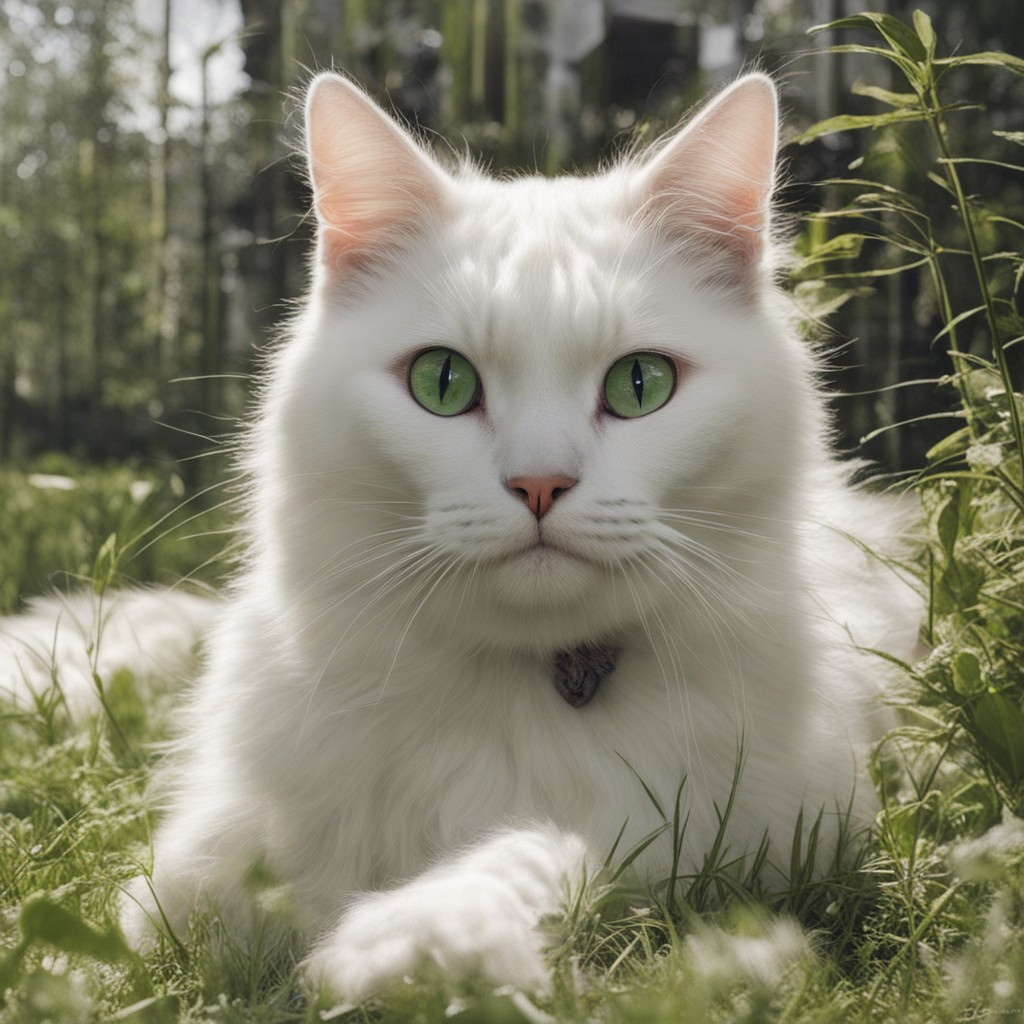

In [6]:
import base64
from io import BytesIO
from PIL import Image

def base64_to_bytes(base64_str: str):
    """Converts base64 string to bytes."""
    return base64.b64decode(base64_str)

def bytes_to_image(byte_data: bytes):
    """Converts byte data to a PIL Image object."""
    return Image.open(BytesIO(byte_data))

b64_str = response.get("artifacts")[0].get("base64")
img = bytes_to_image(base64_to_bytes(b64_str))
img

In [7]:
sdxl.client.last_inputs

{'url': 'https://ai.api.nvidia.com/v1/genai/stabilityai/stable-diffusion-xl',
 'headers': {'Accept': 'application/json',
  'Authorization': SecretStr('**********'),
  'User-Agent': 'langchain-nvidia-ai-endpoints'},
 'json': {'seed': 42,
  'cfg_scale': 5,
  'sampler': 'K_DPM_2_ANCESTRAL',
  'steps': 25,
  'text_prompts': [{'text': 'Cool Russian white cat with green eyes playing in the grass',
    'weight': 1},
   {'text': '', 'weight': -1}]},
 'stream': False}

In addition to the prompt, we can do a bit of hyperparameter tweaking and add some negative prompt components that we'd like to avoid. We will also use the `ImageParser` runnable automatically by calling the `.as_pil()` method.

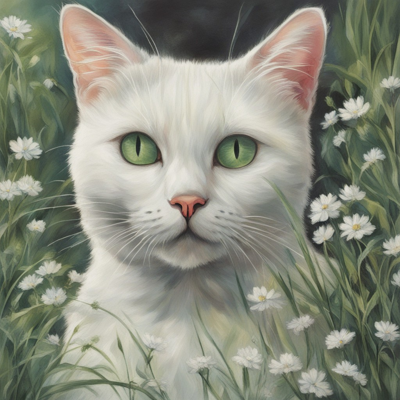

In [8]:
from operator import itemgetter
## Just allows us to get the first output in a functional manner

## Add an extra function to scale the image down
def resize(*args, **kwargs):
    return lambda img: img.resize(*args, **kwargs)

## Eliminate out call's seed argument, reverting to construction seed
payload.pop("seed")

(sdxl.as_pil() | itemgetter(0) | resize((400, 400))).invoke(payload)

Note that under the hood, `as_pil` returns a merger of the `ImageGenModel` object with the `ImageParser` output parser. As a result, you may have trouble interacting with the aggregation. Note that you can reference the first half of the pipeline via `.first` or similar.

## Using with OpenAI

In [9]:
from langchain_nvidia_ai_endpoints.runnables import RunnableNVIDIA
from getpass import getpass
import os

if not os.environ.get("OPENAI_API_KEY", "").startswith("sk-"):
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OPENAI Key: ")

llm = RunnableNVIDIA().mode("openai")
llm.available_models

[Model(id='dall-e-2', model_type='genai'),
 Model(id='dall-e-3', model_type='genai'),
 Model(id='tts-1-1106', model_type='tts'),
 Model(id='tts-1-hd-1106', model_type='tts'),
 Model(id='tts-1-hd', model_type='tts'),
 Model(id='tts-1', model_type='tts'),
 Model(id='whisper-1', model_type='asr')]

Revised Prompt: Imagine a city skyline at night, gleaming with neon green lights. The scene is brimming with a futuristic aesthetic yet remains firmly rooted in realism. Skyscrapers pierce the starlit sky, their silhouettes adorned with the ethereal glow of chartreuse illuminations. Advanced technology is evident everywhere; electronic billboards display vibrant advertisements, while high-speed levitating public transportation zips through the suspended highways. Despite its futuristic appeal, the city maintains a tangible sense of reality, its streets bustling with citizens of various occupations, genders and descents.


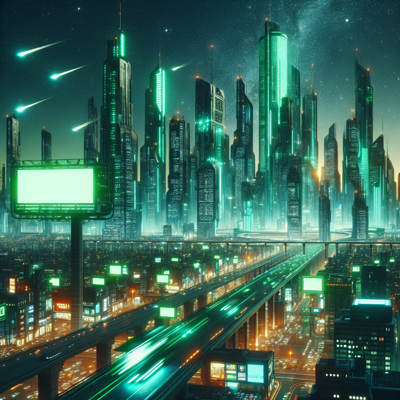

In [10]:
from langchain_nvidia_ai_endpoints.runnables import RunnableNVIDIA
from langchain_core.runnables import RunnableLambda
import requests

dalle = RunnableNVIDIA(model="dall-e-3").mode("openai")

def prompt_to_payload(prompt, n=1):
    return {
        "model": "dall-e-3",
        "prompt": prompt,
        "size": "1024x1024"
    }

def response_to_pil(body):
    data = body.get("data")[0]
    print("Revised Prompt:", data.get("revised_prompt"))
    body = requests.get(data.get("url"), stream=True).raw
    return Image.open(body)

## NOTE: Only first pipe argument needs to be a Runnable for all later to work
pipeline = RunnableLambda(prompt_to_payload) | dalle | response_to_pil | resize((400, 400))

pipeline.invoke("City skyline, neon green tint, aesthetic futuristic realistic")

In [11]:
dalle.client.last_inputs

{'url': 'https://api.openai.com/v1/images/generations',
 'headers': {'Accept': 'application/json',
  'Authorization': SecretStr('**********'),
  'User-Agent': 'langchain-nvidia-ai-endpoints'},
 'json': {'model': 'dall-e-3',
  'prompt': 'City skyline, neon green tint, aesthetic futuristic realistic',
  'size': '1024x1024'},
 'stream': False}

In [12]:
dalle.client.last_response.json()

{'created': 1715436603,
 'data': [{'revised_prompt': 'Imagine a city skyline at night, gleaming with neon green lights. The scene is brimming with a futuristic aesthetic yet remains firmly rooted in realism. Skyscrapers pierce the starlit sky, their silhouettes adorned with the ethereal glow of chartreuse illuminations. Advanced technology is evident everywhere; electronic billboards display vibrant advertisements, while high-speed levitating public transportation zips through the suspended highways. Despite its futuristic appeal, the city maintains a tangible sense of reality, its streets bustling with citizens of various occupations, genders and descents.',
   'url': 'https://oaidalleapiprodscus.blob.core.windows.net/private/org-UOJTPbi1KQQDRdYIgJfVPkYK/user-KFXSm8ag8jgNs5P6PfjZDoIb/img-yKiLAXqw0OBKXfeavdORR4Vk.png?st=2024-05-11T13%3A10%3A03Z&se=2024-05-11T15%3A10%3A03Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-4